# Viscoelastic wave propagator with GSLS model

This tutorial was prepared by Paula Neves de Araujo (paulan@ime.usp.br).

This tutorial is an introduction to the isotropic viscoelastic wave propagator of Spyro using the Generalized Standard Linear Solid (GSLS) model. The tutorial is an adaption of the elastic forward notebook and is a generalization of the Zener model.

First, the notebook environment is configured and the required modules are imported. If you are running this notebook in Google colab, please copy the following code into a code block before running the notebook:

```python
# For use in colab only:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

!pip install git+https://github.com/NDF-Poli-USP/spyro.git

In [2]:
%matplotlib inline
import spyro
import numpy as np

from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [6]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": True,
        "visco_type": 'gsls',
        "tau_sigma_gsls": [Constant(0.002), Constant(0.005)],
        "tau_epsilon_gsls": [Constant(0.001), Constant(0.003)],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])


Note that "viscoelastic" is set to **True**. If this parameter is set to **False**, the elastic wave propagation is performed. We also have the "visco_type" parameter which is used to define the model to be adopted. Three options are implemented for now: 'kelvin_voigt', 'zener' and 'gsls'. In this notebook, we address the GSLS formulation, and we define two lists of viscoelasticity parameters: "tau_sigma_gsls" and "tau_epsilon_gsls". 

The **Generalized Standard Linear Solid (GSLS)** model extends the classical Zener model by incorporating multiple Zener elements (also known as relaxation branches) in parallel. Each branch consists of a spring in parallel with a Kelvin–Voigt element, allowing the model to capture more complex and realistic viscoelastic behaviors such as **frequency-dependent attenuation** and **broadband dispersion**.

The total stress is computed by summing the contributions of the elastic spring and all relaxation branches:

$$
\sigma + \sum_{i=1}^{N} \tau_{\sigma}^{(i)} \, \dot{\sigma}^{(i)} = \lambda \, \text{tr}(\varepsilon) \, I + 2\mu \, \varepsilon + \sum_{i=1}^{N} \tau_{\varepsilon}^{(i)} \left( \lambda \, \text{tr}(\dot{\varepsilon}) \, I + 2\mu \, \dot{\varepsilon} \right)
$$

Alternatively, the stress can be expressed as:

$$
\sigma = \sigma_e + \sum_{i=1}^{N} \sigma^{(i)}
$$

with each branch governed by:

$$
\sigma^{(i)} + \tau_{\sigma}^{(i)} \, \dot{\sigma}^{(i)} = \tau_{\varepsilon}^{(i)} \, \dot{\sigma}_e
$$

where:

- $\sigma$ is the total stress tensor  
- $\varepsilon$ is the strain tensor  
- $\sigma^{(i)}$ is the stress contribution from the *i*-th relaxation mechanism  
- $\tau_{\sigma}^{(i)}$ and $\tau_{\varepsilon}^{(i)}$ are the stress and strain relaxation times for branch *i*  
- $\sigma_e = \lambda \, \text{tr}(\varepsilon) \, I + 2\mu \, \varepsilon$ is the purely elastic stress  
- $I$ is the identity tensor

This model allows for a more accurate representation of real-world viscoelastic materials, especially in seismic modeling, biomechanics, and materials science.


In the following, we build the "wave" object, which is an instance of "wave" type, and also stablish a periodic mesh for the example:

In [7]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Finally, the wave propagation can be performed:

In [8]:
wave.forward_solve()

Viscoelastic GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


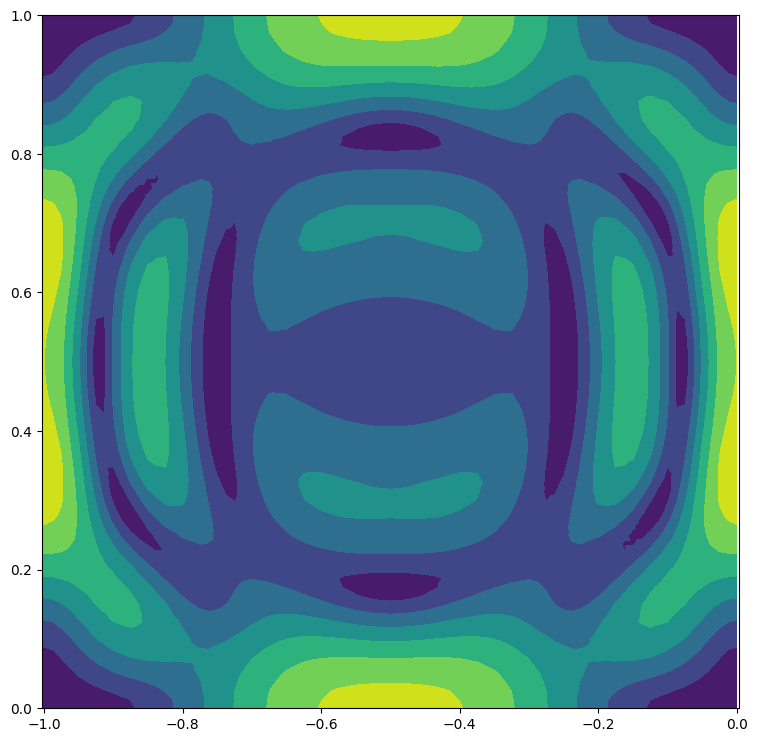

In [9]:
spyro.plots.plot_function(wave.u_n)

In the following, we show that, if the viscoelasticity parameters are null, the results coincide with the elastic case. We redefine the parameters dictionary and set "viscoelastic" to **False**:

In [3]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": False,
        "visco_type": 'gsls',
        "tau_sigma_gsls": [Constant(0.0), Constant(0.0)],
        "tau_epsilon_gsls": [Constant(0.0), Constant(0.0)],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])

Then we run the commands for the wave construction and propagation:

In [12]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Isotropic elastic
Saving Displacement in: results/forward_outputsn0.pvd
Simulation time is:        0.0 seconds


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


We obtain the following result:

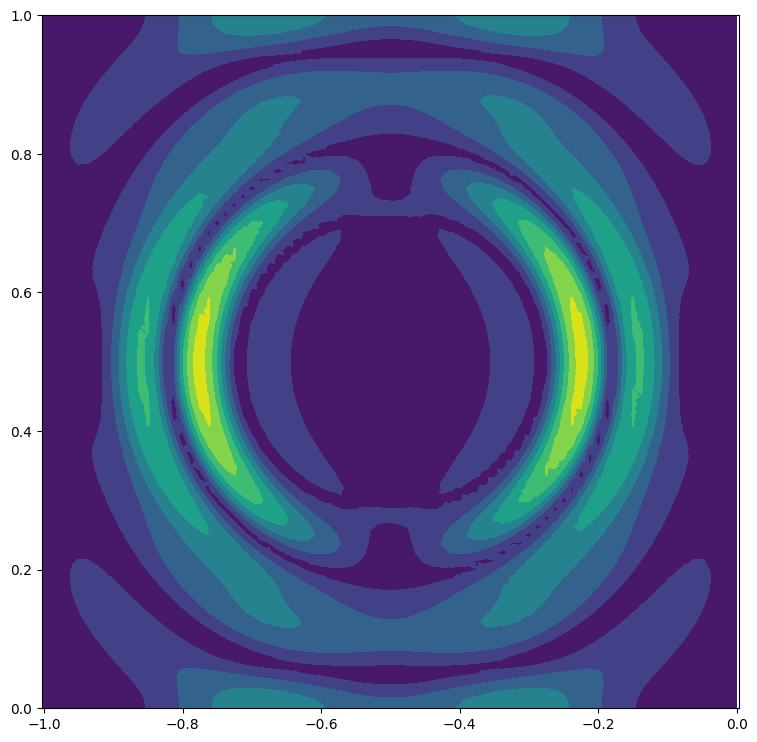

In [13]:
spyro.plots.plot_function(wave.u_n)

Then we run the same code for the GSLS model with null viscoelasticity parameters:

In [16]:
dictionary = {
    "options": {
        "cell_type": "Q",
        "variant": "lumped",
        "degree": 4,
        "dimension": 2,
    },
    "parallelism": {
        "type": "automatic",
    },
    "mesh": {
        "Lz": 1.0,
        "Lx": 1.0,
        "mesh_file": None,
        "mesh_type": "firedrake_mesh",
    },
    "acquisition": {
        "source_type": "ricker",
        "source_locations": [(-0.5, 0.5)],
        "frequency": 5.0,
        "delay": 0.2,
        "delay_type": "time",
        "receiver_locations": spyro.create_transect((-1.9, 1.2), (-1.9, 1.8), 300),
    },
    "time_axis": {
        "initial_time": 0.0,
        "final_time": 0.5,
        "dt": 0.0005,
        "output_frequency": 100,
        "gradient_sampling_frequency": 1,
    },
    "visualization": {
        "forward_output": True,
        "forward_output_filename": "results/forward_output.pvd",
        "fwi_velocity_model_output": False,
        "velocity_model_filename": None,
        "gradient_output": False,
        "gradient_filename": "results/Gradient.pvd",
        "adjoint_output": False,
        "adjoint_filename": None,
        "debug_output": False,
    },
    "viscoelasticity": {
        "viscoelastic": True,
        "visco_type": 'gsls',
        "tau_sigma_gsls": [Constant(0.0), Constant(0.0)],
        "tau_epsilon_gsls": [Constant(0.0), Constant(0.0)],
    },
}

dictionary["synthetic_data"] = {
    "type": "object",
    "density": 0.1,
    "p_wave_velocity": 1.5,
    "s_wave_velocity": 1.0,
    "real_velocity_file": None,
}

dictionary["acquisition"]["amplitude"] = np.array([0, 1])

In [17]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


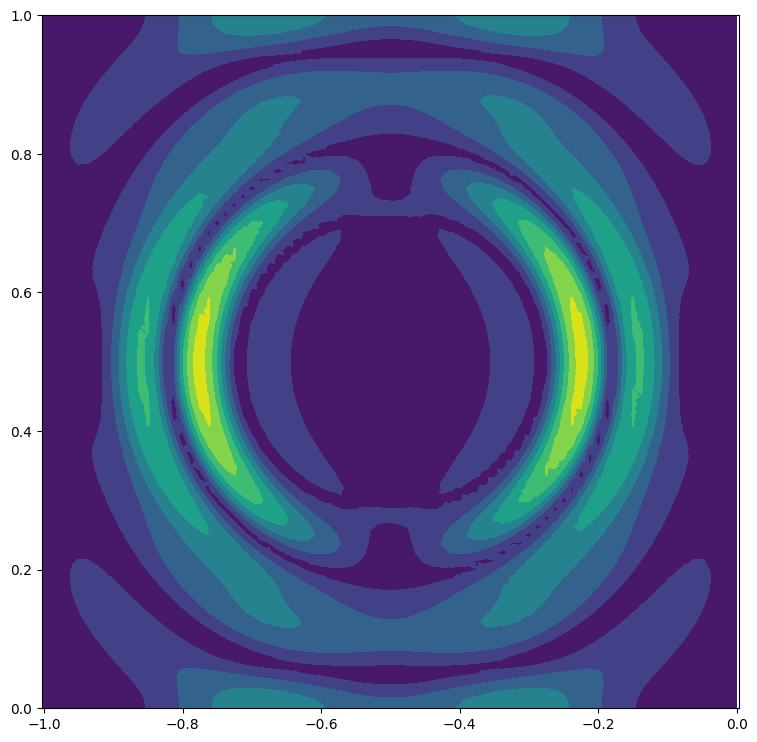

In [18]:
spyro.plots.plot_function(wave.u_n)

Let us set $\tau_\sigma$ and $\tau_\epsilon$ to different values:

In [73]:
dictionary["viscoelasticity"]["tau_sigma_gsls"] = [Constant(0.00001), Constant(0.00003), Constant(0.00005), Constant(0.00008), Constant(0.0001)]
dictionary["viscoelasticity"]["tau_epsilon_gsls"] = [Constant(0.00012), Constant(0.00035), Constant(0.00006), Constant(0.00009), Constant(0.00011)]
dictionary["time_axis"]["dt"] = 0.0005

And then we run the results for the new dictionary:

In [74]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


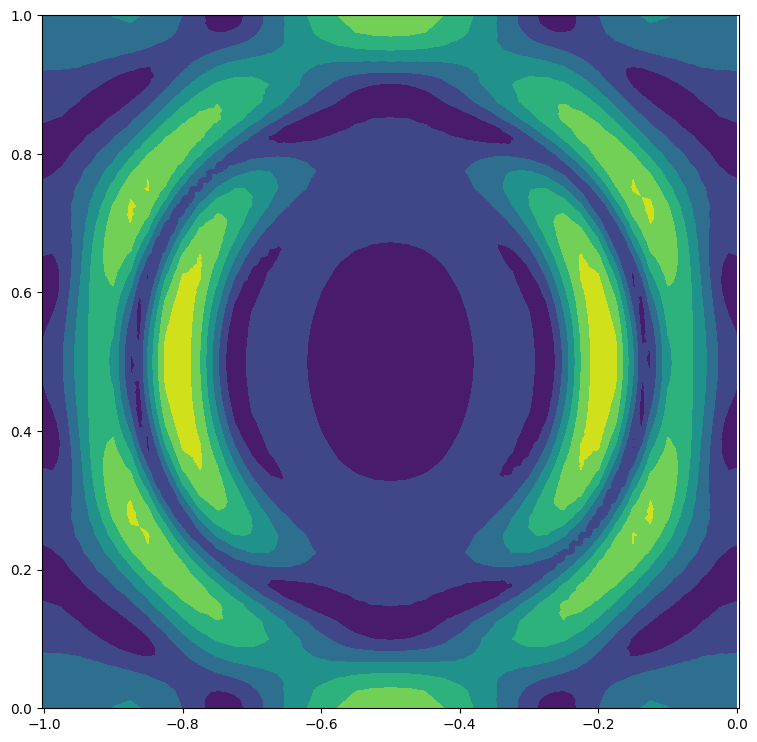

In [75]:
spyro.plots.plot_function(wave.u_n)

We can also run the same test with more pairs $(\tau_\sigma, \tau_\epsilon)$:

In [76]:
dictionary["viscoelasticity"]["tau_sigma_gsls"] = [Constant(0.00001), Constant(0.00003), Constant(0.00005), Constant(0.00008), Constant(0.0001), Constant(0.0002)]
dictionary["viscoelasticity"]["tau_epsilon_gsls"] = [Constant(0.00012), Constant(0.00035), Constant(0.00006), Constant(0.00009), Constant(0.00011), Constant(0.0003)]
dictionary["time_axis"]["dt"] = 0.0005

In [77]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


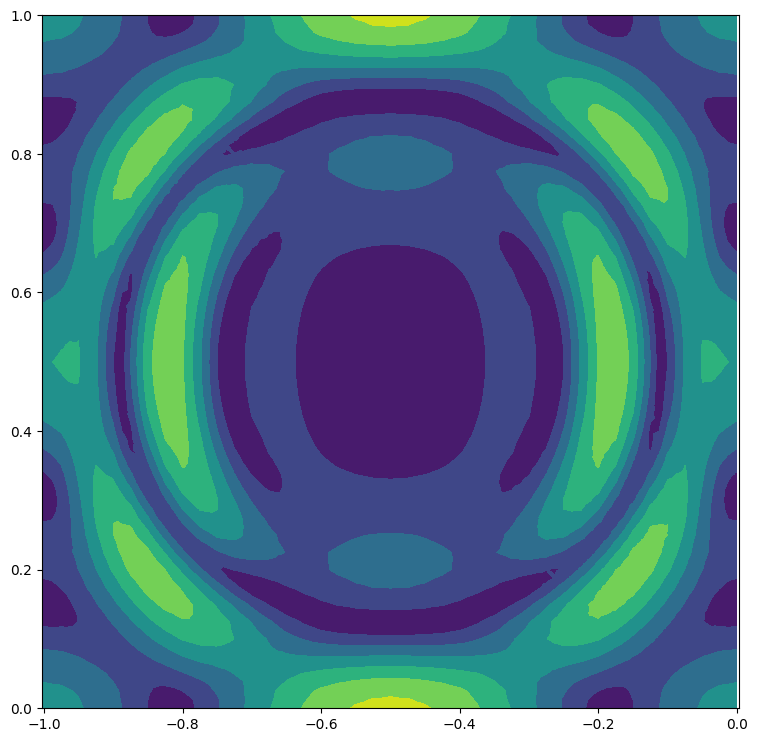

In [78]:
spyro.plots.plot_function(wave.u_n)

In [79]:
dictionary["viscoelasticity"]["tau_sigma_gsls"] = [Constant(0.00001), Constant(0.00003), Constant(0.00005), Constant(0.00008), Constant(0.0001), Constant(0.0002), Constant(0.00025)]
dictionary["viscoelasticity"]["tau_epsilon_gsls"] = [Constant(0.00012), Constant(0.00035), Constant(0.00006), Constant(0.00009), Constant(0.00011), Constant(0.0003), Constant(0.00036)]
dictionary["time_axis"]["dt"] = 0.0005

In [80]:
wave = spyro.IsotropicWave(dictionary)

wave.set_mesh(mesh_parameters={"dx": 0.025, "periodic": True})

wave.forward_solve()

Parallelism type: automatic


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/io/model_parameters.py:579: UserWarning: No velocity model set initially. If using user defined conditional or expression, please input it in the Wave object.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/spyro/solvers/wave.py:84: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


Viscoelastic GSLS
Saving Displacement in: results/forward_outputsn0.pvd


/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(
/home/paulanevesdearaujo/venv-firedrake/lib/python3.12/site-packages/ufl/utils/sorting.py:88: UserWarning: Applying str() to a metadata value of type TensorProductQuadratureRule, don't know if this is safe.
  warnings.warn(


Simulation time is:        0.0 seconds
Simulation time is:       0.05 seconds
Simulation time is:        0.1 seconds
Simulation time is:       0.15 seconds
Simulation time is:        0.2 seconds
Simulation time is:       0.25 seconds
Simulation time is:        0.3 seconds
Simulation time is:       0.35 seconds
Simulation time is:        0.4 seconds
Simulation time is:       0.45 seconds
Simulation time is:        0.5 seconds


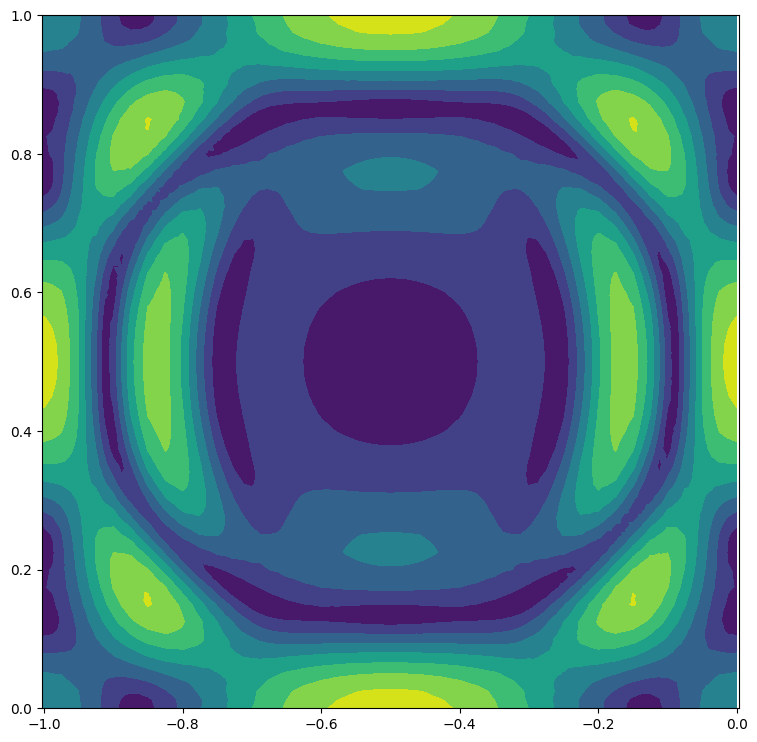

In [81]:
spyro.plots.plot_function(wave.u_n)